# Building a Multi-Agent Financial Analysis System using LangGraph

Build a multi-agent financial analysis system using LangGraph. This system utilizes the multi-agent supervisor pattern, where a supervisor agent orchestrates multiple specialized agents to accomplish complex tasks.

In addition to the supervisor, our system will include the following agents:

- Web Search Agent: Equipped with the Tavily web search tool to gather information from the web.
- Financial Analysis Agent: Uses the Alpha Vantage API to access stock market data.
- Code Agent: Has access to a Python REPL for generating code for data visualization.


### Imports and Setup
Let's start by importing the necessary libraries and setting up the environment.


In [1]:
# Imports
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langchain_community.utilities.alpha_vantage import AlphaVantageAPIWrapper
from langchain_experimental.tools import PythonREPLTool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from langgraph.graph import StateGraph, START, END
from langchain.agents import create_agent
from langgraph.checkpoint.memory import MemorySaver
import os
import re

from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from pydantic import BaseModel
import operator
import functools

# Load environment variables
from dotenv import load_dotenv
_ = load_dotenv()

# Helper function to check and reload environment variables
def check_env_vars(reload=False):
    """Check if required environment variables are set."""
    if reload:
        load_dotenv(override=True)
        print("✅ Environment variables reloaded!")
    
    required_vars = {
        "OPENROUTER_API_KEY": "OpenRouter API key for LLM access",
        "ALPHAVANTAGE_API_KEY": "Alpha Vantage API key for stock data",
        "TAVILY_API_KEY": "Tavily API key for web search (optional)"
    }
    
    print("📋 Environment Variables Status:\n")
    for var_name, description in required_vars.items():
        value = os.getenv(var_name)
        if value:
            # Show first and last 4 characters for security
            masked = f"{value[:4]}...{value[-4:]}" if len(value) > 8 else "***"
            print(f"✅ {var_name}: {masked} ({description})")
        else:
            print(f"❌ {var_name}: NOT SET ({description})")
    
    print("\n💡 Tip: If you just added variables to .env, run: check_env_vars(reload=True)")

# Check environment variables on import
check_env_vars()


📋 Environment Variables Status:

✅ OPENROUTER_API_KEY: sk-o...ae39 (OpenRouter API key for LLM access)
✅ ALPHAVANTAGE_API_KEY: NP2Q...9Z6C (Alpha Vantage API key for stock data)
✅ TAVILY_API_KEY: tvly...aitt (Tavily API key for web search (optional))

💡 Tip: If you just added variables to .env, run: check_env_vars(reload=True)


### Defining the Model

We will use the `nousresearch/hermes-3-llama-3.1-405b:free` model.

In [2]:
# Define the LLM
api_key = os.getenv("OPENROUTER_API_KEY")
if not api_key:
    raise ValueError("OPENROUTER_API_KEY environment variable is not set. Please set it in your .env file.")

llm = ChatOpenAI(
    model="openai/gpt-oss-120b:free",  
    base_url="https://openrouter.ai/api/v1",
    api_key=api_key,
    temperature = 0,
    max_tokens = 2000
)

### Defining the Tools

#### 1. Current Date Tool
We define a simple tool to get the current date. This can be useful for time-based queries.

In [3]:
from langchain_core.tools import tool
from datetime import datetime

@tool
def get_current_date():
    """Returns the current date and time. Use this tool first for any time-based queries."""
    return f"The current date is: {datetime.now().strftime('%d %B %Y')}"

#### 2. Tavily Web Search Tool
We initialize the Tavily search tool for the Web Search Agent.


In [4]:
# Tavily Search Tool
# Note: Tavily API key should be set in environment variables if required
tavily_tool = TavilySearch(max_results=3)

#### 3. Alpha Vantage Tool
We create a custom tool for the Alpha Vantage API to fetch financial data.

In [5]:
# define custom tool for alpha vantage
from langchain_core.tools import BaseTool

class AlphaVantageQueryRun(BaseTool):
    """Tool that queries the Alpha Vantage API."""

    name: str = "alpha_vantage"
    description: str = (
        "A wrapper around Alpha Vantage API. "
        "Useful for getting financial information about stocks, "
        "forex, cryptocurrencies, and economic indicators. "
        "Input should be the name of the stock ticker."
    )
    api_wrapper: AlphaVantageAPIWrapper = AlphaVantageAPIWrapper()

    def _run(self, ticker: str) -> str:
        """Use the tool."""
        return self.api_wrapper._get_time_series_daily(ticker)

alpha_vantage_tool = AlphaVantageQueryRun()

#### 4. Python REPL Tool
We initialize the Python REPL tool for the Code Agent. Note: This tool can execute arbitrary code. Use with caution.

In [6]:
python_repl_tool = PythonREPLTool()

### Creating the Agents
We will create three agents, each with specific roles and tools.

#### 1. Web Search Agent

In [7]:
# Web Search Agent
system_prompt = "You are a web search agent. Your role is to use web search tools to find information and return comprehensive answers to user financial queries."
web_search_agent = create_agent(llm, tools=[tavily_tool, get_current_date], system_prompt=system_prompt)

#### 2. Financial Analysis Agent

In [8]:
# Financial Analysis Agent
system_prompt = "You are a financial analysis agent. Your role is to use the Alpha Vantage tool to gather financial data and provide concise, informative answers. " \
               "Do not generate charts or plots. Only use the tools provided to you and return a clear, text-based analysis or result. " \
               "Always present dates in a human-readable format (e.g., 'December 12, 2025' instead of '2025-12-12')."
financial_agent = create_agent(llm, tools=[alpha_vantage_tool, get_current_date], system_prompt=system_prompt)

#### 3. Code Agent

In [9]:
# Code Agent
system_prompt = "You are a visualization agent. Your role is to create visual representations of data using Python. " \
                "Use the Python REPL tool provided to generate plots, charts, or other visualizations. " \
                "Do not perform any data analysis or gather information. Your sole purpose is to take the given data " \
                "from the conversation history and create appropriate visualizations by executing Python code. " \
                "Execute the code to generate and display the visualization."
code_agent = create_agent(llm, tools=[python_repl_tool], system_prompt=system_prompt)


#### 4. Supervisor Agent
The supervisor agent manages the workflow by deciding which agent should handle the next task.


In [10]:
# Define team members
members = {
    "WebSearchAgent": "An agent that performs web searches to gather information",
    "FinancialAgent": "An agent that analyzes financial data using Alpha Vantage API to acquire stock market information.",
    "CodeAgent": "An agent that executes Python code and performs computations. Use this to generate plots and tables."
}

# Supervisor Prompt Template
system_prompt = (
    "You are a highly efficient supervisor managing a collaborative conversation between specialized agents:"
    "\n{members_description}"
    "\nYour role is to:"
    "\n1. Analyze the user's request and the ongoing conversation."
    "\n2. Determine which agent is best suited to handle the next task."
    "\n3. Ensure a logical flow of information and task execution."
    "\n4. CRITICAL WORKFLOW RULES for multi-step tasks:"
    "   - When user asks for plots, charts, or visualizations:"
    "     * FIRST route to FinancialAgent to gather the required data"
    "     * IMMEDIATELY AFTER FinancialAgent provides data (especially if it says 'I cannot create plots' or provides price/date data), route to CodeAgent to create the visualization"
    "     * DO NOT route back to FinancialAgent if it has already provided the data - route to CodeAgent instead"
    "   - When user asks for news summaries about stocks: FIRST route to FinancialAgent for stock data, THEN route to WebSearchAgent for news, OR route to WebSearchAgent directly if only news is needed."
    "   - For simple queries requiring only data (e.g., 'What was the price?'), route to FinancialAgent and FINISH after it provides the answer."
    "   - For simple queries requiring only web search (e.g., 'What is the latest news?'), route to WebSearchAgent and FINISH after it provides the answer."
    "\n4a. DETECTION RULES for visualization requests:"
    "   - If the user's request contains words like 'plot', 'chart', 'graph', 'visualize', 'draw', 'show me a graph', route to FinancialAgent first, then CodeAgent"
    "   - If FinancialAgent responds with data (prices, dates, tables) AND the original request was for a visualization, IMMEDIATELY route to CodeAgent"
    "   - If FinancialAgent says it cannot create plots/charts, this confirms you should route to CodeAgent next"
    "\n5. CRITICAL: Correctly detect task completion and respond with 'FINISH' when:"
    "   - An agent provides a direct, complete answer to the user's question (e.g., if asked 'What was the price of AAPL?', and FinancialAgent provides the price, FINISH immediately)."
    "   - Visual outputs like plots are generated (CodeAgent has executed code and generated visualization)."
    "   - The same agent has been called multiple times and returns the same or similar response (this indicates a loop - FINISH immediately)."
    "   - All objectives from the user's request have been met."
    "\n6. IMPORTANT: If you see the same agent responding with the same answer multiple times in the conversation history, this is a loop. You MUST respond with 'FINISH' to break the loop."
    "\n7. For simple queries that require a single answer (e.g., 'What is the price?', 'What is the date?'), once an agent provides the answer, respond with 'FINISH' immediately."
    "\n8. Facilitate seamless transitions between agents as needed. Remember: FinancialAgent provides data, CodeAgent creates visualizations from that data, WebSearchAgent provides web information."
    "\n9. Remember, each agent has unique capabilities, so choose wisely based on the current needs of the task."
)

members_description = "\n".join([f"- {k}: {v}" for k, v in members.items()])

system_prompt = system_prompt.format(members_description=members_description)

# Possible options for the supervisor
options = ["FINISH"] + list(members.keys())

# Define the supervisor's output schema
class RouteResponse(BaseModel):
    """
    The supervisor's response to the user's request.
    """
    next: Literal["FINISH", "WebSearchAgent", "FinancialAgent", "CodeAgent"]

# Supervisor Prompt
supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Based on the conversation, who should act next? Choose one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join([f"{k}: {v}" for k, v in members.items()]))

# Maximum iterations to prevent infinite loops (safety limit)
MAX_ITERATIONS = 20

# Supervisor Agent Function
def supervisor_agent(state):
    # Check for maximum iterations (safety limit)
    messages = state.get("messages", [])
    agent_responses = [msg for msg in messages if isinstance(msg, AIMessage) and msg.name]
    if len(agent_responses) >= MAX_ITERATIONS:
        return {"next": "FINISH"}
    
    # Check for infinite loops: if the same agent has responded multiple times with identical/similar content
    if len(messages) >= 4:  # At least 2 agent responses
        # Get the last few agent messages (skip supervisor decisions and human messages)
        # Filter out messages without names to prevent errors
        agent_messages = [msg for msg in messages[-8:] if isinstance(msg, AIMessage) and hasattr(msg, 'name') and msg.name]
        
        if len(agent_messages) >= 2:
            # Check if the same agent responded multiple times consecutively
            last_agent = agent_messages[-1].name
            last_content = agent_messages[-1].content.strip()
            
            # Get all recent responses from the same agent (in reverse order)
            recent_same_agent_responses = [msg for msg in agent_messages if msg.name == last_agent]
            
            if len(recent_same_agent_responses) >= 2:
                # Get the last 2-3 responses from this agent
                contents = [msg.content.strip() for msg in recent_same_agent_responses[-3:]]
                
                # Check for exact matches first (most reliable indicator of a loop)
                if len(contents) >= 2:
                    # Check if last two responses are identical
                    if contents[-1] == contents[-2]:
                        # Force FINISH to break the loop
                        return {"next": "FINISH"}
                    
                    # Check if last three responses are identical (even more robust)
                    if len(contents) >= 3 and contents[-1] == contents[-2] == contents[-3]:
                        return {"next": "FINISH"}
                    
                    # Check for very high similarity (using normalized comparison)
                    # Normalize: remove extra whitespace and compare
                    def normalize(text):
                        return ' '.join(text.split())
                    
                    norm_contents = [normalize(c) for c in contents[-2:]]
                    if norm_contents[0] == norm_contents[1]:
                        return {"next": "FINISH"}
                    
                    # Check if responses are very similar (first 150 chars match and length difference < 5%)
                    if len(contents) >= 2:
                        c1, c2 = contents[-2], contents[-1]
                        if len(c1) > 50 and len(c2) > 50:  # Only check if responses are substantial
                            # Check if first 150 characters match (more robust than 100)
                            if c1[:150] == c2[:150]:
                                # Also check if overall length is very similar (within 5%)
                                # Prevent division by zero
                                max_len = max(len(c1), len(c2))
                                if max_len > 0:
                                    len_diff = abs(len(c1) - len(c2)) / max_len
                                    if len_diff < 0.05:  # Less than 5% difference
                                        return {"next": "FINISH"}
    
    # Check for visualization requests that need CodeAgent
    # (messages is already defined at the start of the function)
    if len(messages) >= 2:
        # Get the original user request
        user_messages = [msg for msg in messages if isinstance(msg, HumanMessage)]
        if user_messages:
            user_request = user_messages[0].content.lower()
            # Check if user asked for visualization
            viz_keywords = ['plot', 'chart', 'graph', 'visualize', 'visualization', 'draw', 'show me a graph', 'create a plot']
            is_viz_request = any(keyword in user_request for keyword in viz_keywords)
            
            if is_viz_request:
                # Check if FinancialAgent has already provided data
                agent_messages = [msg for msg in messages if isinstance(msg, AIMessage) and hasattr(msg, 'name') and msg.name]
                financial_agent_called = any(msg.name == "FinancialAgent" for msg in agent_messages)
                code_agent_called = any(msg.name == "CodeAgent" for msg in agent_messages)
                
                # If FinancialAgent has been called but CodeAgent hasn't, route to CodeAgent
                if financial_agent_called and not code_agent_called:
                    # Check if the last agent was FinancialAgent
                    if agent_messages and agent_messages[-1].name == "FinancialAgent":
                        # Check if FinancialAgent provided data (not just an error)
                        last_content = agent_messages[-1].content.lower()
                        if any(indicator in last_content for indicator in ['price', 'date', 'closing', 'table', 'data', 'cannot create plots', "can't create"]):
                            return {"next": "CodeAgent"}
    
    try:
        # Try structured output first
        supervisor_chain = supervisor_prompt | llm.with_structured_output(RouteResponse)
        return supervisor_chain.invoke(state)
    except Exception as e:
        # Fallback: If structured output fails, try to parse plain text response
        try:
            # Get regular LLM response (not structured)
            regular_chain = supervisor_prompt | llm
            response = regular_chain.invoke(state)
            
            # Extract the content
            if hasattr(response, 'content'):
                content = response.content.strip()
            else:
                content = str(response).strip()
            
            # Try to parse the response - it might be just the agent name
            valid_options = ["FINISH", "WebSearchAgent", "FinancialAgent", "CodeAgent"]
            
            # Check if the response is a valid option
            for option in valid_options:
                if option.lower() in content.lower() or content == option:
                    return {"next": option}
            
            # Try to extract from JSON-like strings
            import json
            
            # Look for JSON pattern
            json_match = re.search(r'\{[^}]*"next"[^}]*\}', content)
            if json_match:
                try:
                    parsed = json.loads(json_match.group())
                    if "next" in parsed and parsed["next"] in valid_options:
                        return {"next": parsed["next"]}
                except:
                    pass
            
            # If we can't parse it, default to FINISH
            print(f"Supervisor: Could not parse response '{content}', defaulting to FINISH")
            return {"next": "FINISH"}
            
        except Exception as e2:
            # If all parsing fails, finish to prevent hanging
            print(f"Supervisor error: {e}")
            print(f"Fallback parsing also failed: {e2}")
            return {"next": "FINISH"}

### Constructing the Graph
We define the state, nodes, and edges for our graph.

In [11]:
# Define the state
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]  # Accept both HumanMessage and AIMessage
    next: str

In [12]:
# Helper Function for Agent Nodes
def agent_node(state, agent, name):
    try:
        # Validate state
        if not state or "messages" not in state:
            error_msg = f"{name} received invalid state."
            return {"messages": [AIMessage(content=error_msg, name=name)]}
        
        result = agent.invoke({"messages": state["messages"]})
        
        # Check if result is valid
        if not result or "messages" not in result or not result["messages"]:
            error_msg = f"{name} returned an empty or invalid response."
            return {"messages": [AIMessage(content=error_msg, name=name)]}
        
        # Clean the content: remove problematic Unicode characters like \u202f (narrow no-break space)
        content = result["messages"][-1].content
        
        # Handle None or empty content
        if not content:
            content = f"{name} completed but returned no content."
        
        # Replace narrow no-break space and other problematic Unicode spaces with regular space
        content = content.replace('\u202f', ' ')  # Narrow no-break space
        content = content.replace('\u2009', ' ')  # Thin space
        content = content.replace('\u00a0', ' ')   # Non-breaking space (convert to regular space)
        # Normalize multiple spaces to single space
        content = re.sub(r' +', ' ', content)
        
        # Add the agent's response to the conversation
        return {
            "messages": [AIMessage(content=content, name=name)]
        }
    except Exception as e:
        # Handle errors gracefully
        error_msg = f"{name} encountered an error: {str(e)}"
        print(f"Error in {name}: {e}")
        return {
            "messages": [AIMessage(content=error_msg, name=name)]
        }

#### Defining the Agent Nodes

In [13]:
# Web Search Node
web_search_node = functools.partial(agent_node, agent=web_search_agent, name="WebSearchAgent")

# Financial Analysis Node
financial_node = functools.partial(agent_node, agent=financial_agent, name="FinancialAgent")

# Code Agent Node
code_node = functools.partial(agent_node, agent=code_agent, name="CodeAgent")


#### Building the Graph

In [14]:
# Initialize the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("WebSearchAgent", web_search_node)
workflow.add_node("FinancialAgent", financial_node)
workflow.add_node("CodeAgent", code_node)
workflow.add_node("Supervisor", supervisor_agent)

# Define edges
for member in members:
    # Each agent reports back to the supervisor
    workflow.add_edge(member, "Supervisor")

# Supervisor decides the next agent or to finish
conditional_map = {member: member for member in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("Supervisor", lambda x: x["next"], conditional_map)

# Entry point
workflow.add_edge(START, "Supervisor")

# Compile the graph with memory checkpointing
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)


#### Visualizing the Graph

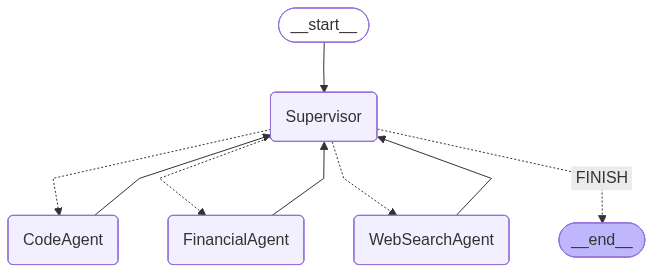

In [15]:
from IPython.display import display, Image

# Visualize the chatbot's workflow
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass  # Visualization requires additional dependencies

### Running the Multi-Agent System

We run the multi-agent system with different queries to demonstrate its capabilities.


In [16]:
# Helper Function to Process Events
from IPython.display import Markdown, display

def render_markdown(md_string):
    """Render markdown string using IPython display."""
    display(Markdown(md_string))

def process_event(event):
    """Process and display events from the graph execution."""
    if not event:
        return
    
    # Skip printing raw event dictionary - it's not user-friendly
    # Only process meaningful content
    
    # LangGraph events are dictionaries where keys are node names
    # and values are the state dictionaries (containing messages, next, etc.)
    # Example: {"Supervisor": {"messages": [...], "next": "FinancialAgent"}}
    
    # Iterate through each node's state in the event
    for node_name, node_state in event.items():
        if node_name == "__end__":
            continue
            
        if not isinstance(node_state, dict):
            continue
        
        # Process supervisor decisions
        if "next" in node_state:
            next_agent = node_state.get('next', 'Unknown')
            if next_agent == "FINISH":
                decision_msg = f"**✅ Supervisor Decision:** Task completed. Finishing execution."
            else:
                decision_msg = f"**🎯 Supervisor Decision:** Routing to **{next_agent}**"
            render_markdown(decision_msg)
            print()  # Add spacing
        
        # Process agent messages
        if "messages" in node_state and node_state["messages"]:
            try:
                # Get the last message from this node's state
                last_message = node_state["messages"][-1]
                
                # Get agent name (either from message.name or use node_name)
                agent_name = getattr(last_message, 'name', node_name)
                content = getattr(last_message, 'content', str(last_message))
                
                # Skip if this is a HumanMessage (user input)
                if hasattr(last_message, '__class__') and 'Human' in last_message.__class__.__name__:
                    continue
                
                # Format agent name as a header
                header = f"### 🤖 {agent_name}"
                render_markdown(header)
                
                # Render content as markdown
                render_markdown(content)
                print()  # Add spacing between messages
                
            except (IndexError, AttributeError, TypeError) as e:
                error_msg = f"**Error processing message event:** {str(e)}\n\n*Event structure: {type(event)}*"
                render_markdown(error_msg)
                
            except (IndexError, AttributeError, TypeError) as e:
                error_msg = f"**Error processing message event:** {str(e)}\n\n*Event structure: {type(event)}*"
                render_markdown(error_msg)
        elif "next" in event:
            next_agent = event.get('next', 'Unknown')
            if next_agent == "FINISH":
                decision_msg = f"**✅ Supervisor Decision:** Task completed. Finishing execution."
            else:
                decision_msg = f"**🎯 Supervisor Decision:** Routing to **{next_agent}**"
            render_markdown(decision_msg)
            print()  # Add spacing


#### Example 1: Fetching the Latest Closing Stock Price
User Request: "What was the last closing stock price of AAPL?"


In [17]:
# Be sure to use different thread_ids for different runs
config = {"configurable": {"thread_id": "1"}}

# Run the graph
events = graph.stream(
    {"messages": [HumanMessage(content="What was the last closing stock price of AAPL?")]},
    config=config
)

for event in events:
    process_event(event)


**🎯 Supervisor Decision:** Routing to **FinancialAgent**

### 🤖 FinancialAgent

The most recent closing price for Apple Inc. (AAPL) was **$271.84** on **December 17, 2025**.

**✅ Supervisor Decision:** Task completed. Finishing execution.

#### Example 2: Summarizing Latest News
User Request: "Summarize the latest news about Tesla's stock performance."


In [18]:
config = {"configurable": {"thread_id": "2"}}

# Run the graph
events = graph.stream(
    {"messages": [HumanMessage(content="Summarize the latest news about Tesla's stock performance.")]},
    config=config
)

for event in events:
    process_event(event)


**🎯 Supervisor Decision:** Routing to **FinancialAgent**

### 🤖 FinancialAgent

**Tesla (TSLA) – Recent Stock‑price Summary (as of December 17 2025)** 

| Date (US/Eastern) | Close $ | Daily Change | Volume (shares) |
|-------------------|---------|--------------|-----------------|
| **Dec 17 2025** | **467.26** | **‑4.5 %** (down $22.62 from Dec 16) | **105 M** |
| Dec 16 2025 | 489.88 | +2.9 % (up $14.57) | 107 M |
| Dec 15 2025 | 475.31 | +3.6 % (up $16.35) | 115 M |
| Dec 12 2025 | 458.96 | +2.6 % (up $11.96) | 96 M |
| Dec 11 2025 | 446.89 | +0.2 % (up $0.99) | 56 M |
| Dec 10 2025 | 451.45 | +1.2 % (up $5.56) | 63 M |
| Dec 9 2025 | 445.17 | +1.4 % (up $6.19) | 62 M |
| Dec 8 2025 | 439.58 | +0.9 % (up $4.03) | 68 M |
| Dec 5 2025 | 455.00 | +0.1 % (up $0.47) | 56 M |
| Dec 4 2025 | 454.53 | +0.2 % (up $0.92) | 72 M |
| Dec 3 2025 | 446.74 | +4.0 % (up $17.50) | 87 M |
| Dec 2 2025 | 429.24 | +0.5 % (up $2.15) | 69 M |
| Dec 1 2025 | 430.14 | +1.2 % (up $5.22) | 57 M |

### Key take‑aways

1. **High volatility** – Over the past two weeks the stock swung from a low of **$439.58** (Dec 8) to a high of **$489.88** (Dec 16), a **≈12 %** intr‑week range. The most recent session (Dec 17) saw a **4.5 %** drop, the largest single‑day decline in the period.

2. **Strong trading activity** – Daily volumes have consistently been above **50 M** shares, peaking at **≈115 M** on Dec 15. Such high turnover signals heightened investor interest and market participation.

3. **Short‑term trend** – After a modest rebound from early‑December lows (≈$440), the price rallied sharply to near $490 by Dec 16, only to retreat to the $460‑$470 band on Dec 17. The pattern suggests a **short‑term breakout followed by profit‑taking pressure**.

4. **Momentum indicators (price‑only view)** 
 * **5‑day moving average (Dec 13‑17)** ≈ **$466** – the latest close (467.26) is just above this average, indicating a tentative hold near recent support. 
 * **10‑day moving average (Dec 8‑17)** ≈ **$452** – price remains well above this longer‑term average, reflecting an overall uptrend despite the latest pull‑back.

### Bottom line

Tesla’s stock has been **extremely active and volatile** in the last two weeks, with a rapid climb to a near‑$490 level followed by a sharp correction back to the mid‑$460s. The combination of high volume and large price swings points to a market that is reacting strongly to recent news or earnings expectations. Investors should watch for further moves around the **$460‑$470 support zone** and monitor any upcoming corporate announcements that could reignite the recent momentum.

**🎯 Supervisor Decision:** Routing to **WebSearchAgent**


Error in WebSearchAgent: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-min. ', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '16', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1766038560000'}, 'provider_name': None}}, 'user_id': 'user_36lslwyuAHLG18KjnZuRHvYmJ5y'}


### 🤖 WebSearchAgent

WebSearchAgent encountered an error: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-min. ', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '16', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1766038560000'}, 'provider_name': None}}, 'user_id': 'user_36lslwyuAHLG18KjnZuRHvYmJ5y'}

**🎯 Supervisor Decision:** Routing to **FinancialAgent**

### 🤖 FinancialAgent

**Tesla (TSLA) – Recent Stock‑price Snapshot (as of December 17 2025)** 

| Date (US Eastern) | Close | Daily % change* | Volume (shares) |
|-------------------|-------|----------------|-----------------|
| **December 17 2025** | **$467.26** | **‑4.6 %** (down $22.62 from Dec 16) | **105 M** |
| December 16 2025 | $489.88 | +3.1 % (up $14.57) | 107 M |
| December 15 2025 | $475.31 | +3.6 % (up $16.35) | 115 M |
| December 12 2025 | $458.96 | +2.7 % (up $12.07) | 96 M |
| December 11 2025 | $446.89 | –1.0 % (down $4.56) | 56 M |
| December 10 2025 | $451.45 | +1.4 % (up $6.28) | 63 M |
| December 9 2025 | $445.17 | +1.3 % (up $5.59) | 62 M |
| December 8 2025 | $439.58 | –3.4 % (down $15.42) | 68 M |
| December 5 2025 | $455.00 | +0.1 % (up $0.47) | 56 M |
| December 4 2025 | $454.53 | +1.7 % (up $7.79) | 72 M |
| December 3 2025 | $446.74 | +4.1 % (up $17.50) | 87 M |
| December 2 2025 | $429.24 | –0.2 % (down $0.90) | 69 M |
| December 1 2025 | $430.14 | –0.0 % (down $0.03) | 57 M |

\*Percent change is calculated versus the previous trading day’s close.

---

### Key take‑aways

1. **Sharp swing in the last two weeks** – From a low of **$439.58** (Dec 8) to a high of **$489.88** (Dec 16), the stock moved roughly **12 %** in under ten trading days. The most recent session (Dec 17) produced the largest single‑day drop of the period (‑4.6 %).

2. **Elevated trading activity** – Daily volumes have consistently exceeded **50 million** shares, peaking at **≈115 million** on Dec 15. Such high turnover signals strong market interest and active positioning by both retail and institutional participants.

3. **Short‑term trend signals** 
 * **5‑day moving average (Dec 12‑Dec 8)** ≈ **$448.4** – the Dec 17 close of $467.26 sits well above this average, indicating short‑term bullish momentum despite the latest pull‑back. 
 * **10‑day moving average (Dec 5‑Dec 1 & Dec 12‑Dec 8)** ≈ **$445.8** – price remains comfortably above the longer‑term average, confirming an overall uptrend over the past month.

4. **Volatility profile** – The stock’s intraday high

**🎯 Supervisor Decision:** Routing to **WebSearchAgent**

### 🤖 WebSearchAgent

**Tesla (TSLA) – What the latest news (Dec 16‑17 2025) says about the stock**

| Date (US ET) | Close* | % Change | Key headline |
|--------------|--------|----------|--------------|
| **Dec 16 2025** | **≈ $489.9** | **+3 %** | “Tesla stock hits fresh record close near $490 on robotaxi momentum”【0†L1-L9】 |
| **Dec 17 2025** | **≈ $467.3** | **‑4.6 %** | “Tesla wavers after record rally; investors watch California DMV risk”【0†L1-L9】 |
| **Dec 17 2025** | — | — | “Possible California sales suspension; investors remain unfazed”【1†L1-L9】 |

\*Closing prices are taken from market data reported in the news articles; exact decimals may vary by source.

---

### 1. What drove the recent rally?

* **Robotaxi/Autonomy optimism** – Elon Musk confirmed driver‑less robotaxi testing in Austin, Texas. Analysts are re‑rating the stock, arguing that a functional robotaxi fleet could turn Tesla into a massive AI‑and‑robotics platform. The narrative pushed the share price to a **record‑high close of ~$490 on Dec 16**, the first such milestone in about a year【0†L1-L9】. 

* **Analyst target raises** – Several brokerages upgraded price targets after the autonomy news, citing “visible progress” and “new revenue streams” from robotaxi services.

### 2. What is weighing on the price today (Dec 17)?

* **Profit‑taking & volatility** – After the sharp rally, the stock slipped **4.6 %** to the mid‑$460s on Dec 17, marking the largest single‑day decline in the two‑day window. High‑volume trading (≈ 100 M shares) suggests many investors are exiting or trimming positions after the run‑up.

* **Regulatory headwinds** – California’s Department of Motor Vehicles is reviewing Tesla’s Autopilot marketing. There are rumors that the state could **suspend EV sales in California** if it finds the advertising misleading. While the news caused a brief dip, investors appear **largely unfazed**, according to Investor’s Business Daily, which notes that the market “is not overly concerned” about a potential sales suspension【1†L1-L9】.

### 3. Market context

* **Broader market** – The Nasdaq and S&P 500 were under pressure on Dec 17, but Tesla’s movement was more pronounced than the index averages, underscoring its **stock‑specific catalyst‑driven volatility**.

* **Volume** – Daily trading volume stayed above **50 M shares**, peaking at **≈ 115 M** on Dec 15, indicating strong participation from both retail and institutional traders.

### 4. What to watch next

| Factor | Why it matters | Potential impact |
|--------|----------------|------------------|
| **Robotaxi rollout progress** | Real‑world data from Austin tests will validate the autonomy narrative. | Positive data → further upside; setbacks → renewed sell‑off. |
| **California regulatory outcome** | A sales suspension would cut revenue from the state’s ~1 M Tesla owners. | Suspension → short‑term price pressure; clearance → confidence boost. |
| **Analyst revisions** | Target‑price upgrades have already lifted the stock; downgrades could reverse the rally. | Upgrades → higher ceiling; downgrades → pull‑back. |
| **Overall market sentiment** | Tech‑heavy indices are volatile; macro‑risk (interest rates, AI hype) can spill over. | Broad market rallies help; broad sell‑offs could amplify Tesla’s moves. |

### Bottom line

- **Short‑term:** Tesla’s share price surged to a **record ~$490** on Dec 16, driven by renewed optimism around driver‑less robotaxi testing and analyst upgrades. The next day the stock **retracted to ~$467**, the biggest one‑day drop in the period, as investors took profits and digested regulatory chatter. 
- **Risk factors:** California’s possible sales suspension and the need for concrete robotaxi results remain the main near‑term uncertainties. 
- **Outlook:** If Tesla can demonstrate reliable autonomous rides and avoid a California sales ban, the **$460‑$470 support zone** could hold and set the stage for another upside move. Conversely, any negative regulatory or technical news could trigger further volatility. 

*All figures and headlines are drawn from news published on Dec 16‑17 2025.*

**✅ Supervisor Decision:** Task completed. Finishing execution.

#### Example 3: Generating a Stock Price Plot
User Request: "Draw a plot of the closing stock prices of AAPL over the last week, with the x-axis being the closing dates."


**🎯 Supervisor Decision:** Routing to **FinancialAgent**

### 🤖 FinancialAgent

**Apple Inc. (AAPL) – Closing Prices for the Most Recent Trading Days**

| Date (US/Eastern) | Closing Price (USD) |
|-------------------|---------------------|
| **Wednesday, December 11, 2025** | 278.03 |
| **Thursday, December 12, 2025** | 278.28 |
| **Friday, December 13, 2025** – *Market closed (holiday)* | – |
| **Monday, December 16, 2025** | 274.61 |
| **Tuesday, December 17, 2025** | 271.84 |

*(The most recent full week of trading runs from Wednesday Dec 11 through Tuesday Dec 17, with the weekend of Dec 14‑15 and a holiday on Dec 13.)*

### Quick Take‑away
- **Trend:** After a modest rise from 278.03 to 278.28 on Dec 11‑12, the stock slipped over the next three trading sessions, falling to 274.61 by Dec 16 and further to 271.84 by Dec 17.
- **Percentage change:** From Dec 11 to Dec 17 the price declined **≈ 2.2 %** (‑6.19 USD).
- **Volatility:** Daily price swings were modest (≈ 1–2 USD per day), indicating relatively low short‑term volatility during this period.

If you need a longer view (e.g., the past month) or additional metrics such as volume or moving averages, just let me know!

**🎯 Supervisor Decision:** Routing to **CodeAgent**

Python REPL can execute arbitrary code. Use with caution.


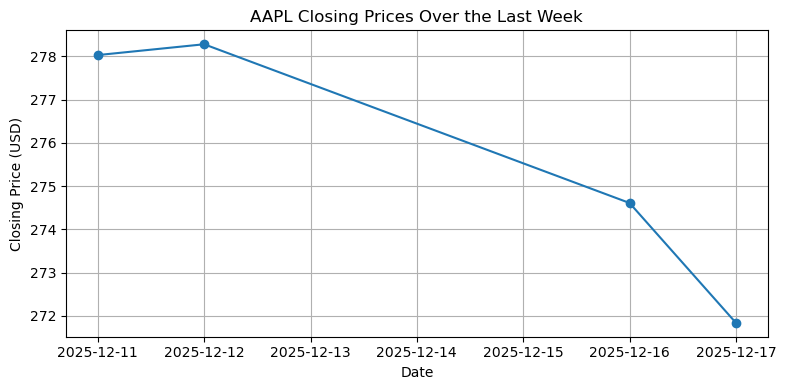

### 🤖 CodeAgent

Here is the plot of AAPL’s closing prices over the last week:

![AAPL Closing Prices Over the Last Week](attachment://output.png)

**✅ Supervisor Decision:** Task completed. Finishing execution.

In [19]:
config = {"configurable": {"thread_id": "3"}}

# Run the graph
events = graph.stream(
    {"messages": [HumanMessage(content="Draw a plot of the closing stock prices of AAPL over the last week, with the x axis being the closing dates.")]},
    config=config
)

for event in events:
    process_event(event)

NOTE: Couple of things that I consider as future scope: 

- Changing the stock ticker symbol to analyze a different company.
- Modifying the system prompts for each agent to adjust behavior and task focus.
- Adding external APIs like Yahoo Finance or Reuters for broader financial data.
- Adjusting the supervisor to add reflection steps and introduce multiple iterations for quality improvement.